In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import pprint
import itertools
import pickle
import sklearn
import dask
import dask.dataframe as dd
import dask.array as da
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### Find new MSA-technology fields appearing after 1990

In [2]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas()
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl").tolist()
# Get relevant US Patents
pdf = pdf.loc[~pdf["patent"].isin(dup_pats)]

In [33]:
# Get number of primary class patents by MSA, and year of their first appearance
p2 = pdf.groupby(["inv_msa", "primclass"]).size()
# Only get primary classes with more than 50 patents
p2 = p2.loc[p2 >= 50].reset_index().rename(columns={0:"size"})
# Date of first appearance
p3 = pdf[["inv_msa", "primclass", "gyear"]].sort_values(["inv_msa", "primclass", "gyear"]).drop_duplicates(["inv_msa", "primclass"])
# Merge
p2 = p2.merge(p3, how="left", on=["inv_msa", "primclass"]).rename(columns={"gyear": "first_gyear"})

# New technology fields after 1990
p3 = p2.loc[p2["first_gyear"] >= 1990]

# Subfield
p3["msa_pc"] = list(zip(p3["inv_msa"], p3["primclass"]))

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Find related subfields
1. Find related MSA-subfields
2. Gather all patents granted within 10 years of new subfield appearing in both new subfield and related subfield

In [36]:
# Primary class random sample
ns = fastparquet.ParquetFile("DataStore/2018-07-P2/Reg0726/reg_naics_name_sim_tr_0726.parq").to_pandas()
ns["op_msa_pc"] = list(zip(ns["op_inv_msa"], ns["op_primclass"]))
ns["tp_msa_pc"] = list(zip(ns["tp_inv_msa"], ns["tp_primclass"]))
ns = ns.loc[ns["op_msa_pc"].isin(p3["msa_pc"])]

In [39]:
# Find highly similar MSA-PC subfields
ns2 = ns.loc[ns["norm_sim_mean_docvecs_pc_msa"] >= 1.5, ["tp_msa_pc", "op_msa_pc",
"inv_msa_match", "year_group", "sim_mean_docvecs_pc_msa", "norm_sim_mean_docvecs_pc_msa"]].drop_duplicates()

ns3 = ns2[["tp_msa_pc", "op_msa_pc"]]

# Merge with first year
ns3 = ns3.merge(p3.add_prefix("op_"), how="left", on = ["op_msa_pc"]).drop(["op_inv_msa", "op_primclass"],1)

In [ ]:
pdf["msa_pc"] = list(zip(pdf["inv_msa"], pdf["primclass"]))

%time tmp = {mp+(yr,): pdf.loc[(pdf["msa_pc"] == mp) & (pdf["gyear"].isin(range(yr, yr+10))), "patent"].tolist() \
for mp, yr in zip(ns3["tp_msa_pc"], ns3["op_first_gyear"])}
%time omp = {mp+(yr,): pdf.loc[(pdf["msa_pc"] == mp) & (pdf["gyear"].isin(range(yr, yr+10))), "patent"].tolist() \
for mp, yr in zip(ns3["op_msa_pc"], ns3["op_first_gyear"])}
    

CPU times: user 4min 44s, sys: 358 ms, total: 4min 45s
Wall time: 4min 42s


In [47]:
# Patents for each MSA-PC
ns3["tp_msa_pc_pats"] = [tmp[mp+(yr,)] for mp, yr in zip(ns3["tp_msa_pc"], ns3["op_first_gyear"])]
ns3["op_msa_pc_pats"] = [omp[mp+(yr,)] for mp, yr in zip(ns3["op_msa_pc"], ns3["op_first_gyear"])]

In [49]:
ns3.to_pickle("DataStore/2018-08/related_field_pats_0913.pkl")

In [48]:
ns3.head()

,tp_msa_pc,op_msa_pc,op_size,op_first_gyear,tp_msa_pc_pats,op_msa_pc_pats
0,"(New York-Northern New Jersey-Long Island, NY-...","(Atlanta-Sandy Springs-Marietta, GA, 707.0)",189,1992,"[5388257, 5412808, 5491817, 5515534, 5551023, ...","[5161223, 5202981, 5291593, 5313629, 6226650, ..."
1,"(Colorado Springs, CO, 713.0)","(Colorado Springs, CO, 713.0)",60,1995,"[5469553, 5768391, 5991890, 6000037, 6033441, ...","[5469553, 5768391, 5991890, 6000037, 6033441, ..."
2,"(Boston-Cambridge-Quincy, MA-NH, 715.0)","(Seattle-Tacoma-Bellevue, WA, 707.0)",2038,1995,"[5392390, 5396587, 5404295, 5416900, 5418898, ...","[5392427, 5495604, 5506983, 5594898, 5701460, ..."
3,"(Washington-Arlington-Alexandria, DC-VA-MD-WV,...","(Kansas City, MO-KS, 370.0)",640,1991,"[4987570, 5051984, 5079760, 5095481, 5099476, ...","[4999831, 5535200, 5606553, 5636210, 5742605, ..."
4,"(Mankato-North Mankato, MN, 800.0)","(Mankato-North Mankato, MN, 800.0)",67,2000,"[6075186, 6180856, 6188001, 6730836, 6759577, ...","[6075186, 6180856, 6188001, 6730836, 6759577, ..."


### Random pairs from related subfields

In [65]:
# Add max length of each list of patents
ns3["max_len"] = [max(len(i), len(j)) for i,j in zip(ns3["tp_msa_pc_pats"], ns3["op_msa_pc_pats"])]

def rand_list(l, nlen):
    try:
        s = np.random.choice(l, size=nlen, replace=True)
    except Exception:
        s = [np.nan]
    return s

rp = [list(zip(rand_list(i, nlen), rand_list(j, nlen))) for i,j, nlen \
      in zip(ns3["tp_msa_pc_pats"].tolist(), ns3["op_msa_pc_pats"].tolist(), ns3["max_len"].tolist())]
rp = [item for sublist in rp for item in sublist]

rs = pd.DataFrame({"tp": [i[0] for i in rp], "op": [i[1] for i in rp]})

# Drop missing values
rs = rs.dropna(how="any")

In [66]:
# Get similarity
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])


import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]

print("Getting row values")
print(datetime.datetime.now())
pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pat_dict = dict(zip(pat_dict, range(len(pat_dict))))

l2 = rs

for dm in dms:
    print((dm,"started"))
    print("Loading matrix and dict")
    print(datetime.datetime.now())
    # Store copy as array
    l3 = l2.loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys()), ["tp", "op"]].copy()

    if dm == "ldavecs":
        ncols = 60
    else:
        ncols = 100

    pm = fastparquet.ParquetFile("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm))\
.to_pandas().values

    # Convert to chunks
    print("Getting chunks")
    print(datetime.datetime.now())
    # Split into chunks
    n_rows = 3000
    n_chunks = int(np.round(len(l3)/n_rows))
    tp_chunks = grouper(n_rows, pm[[pat_dict[p[1]] for p in l3["tp"].iteritems()]])
    op_chunks = grouper(n_rows, pm[[pat_dict[p[1]] for p in l3["op"].iteritems()]])
    del(pm)
    chunks = itertools.zip_longest(tp_chunks, op_chunks)

    print("Getting patent pair cosine similarity")
    print(datetime.datetime.now())
    # Cosine

    cos_dis = np.empty(len(l3))

    for r, c in enumerate(chunks):
        cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))

    l3["sim_{0}".format(dm)] = 1-cos_dis
    
    # Rename columns
    l2 = l2.merge(l3, how = "left", on = ["tp", "op"])
    del(l3)
    print("finished")
    print(datetime.datetime.now())

Getting row values
2018-09-13 13:43:22.889860
('ldavecs', 'started')
Loading matrix and dict
2018-09-13 13:43:24.924251
Getting chunks
2018-09-13 13:43:48.323363
Getting patent pair cosine similarity
2018-09-13 13:43:51.381964
finished
2018-09-13 13:44:14.728588
('docvecs', 'started')
Loading matrix and dict
2018-09-13 13:44:14.728706
Getting chunks
2018-09-13 13:44:39.747145
Getting patent pair cosine similarity
2018-09-13 13:44:44.868895
finished
2018-09-13 13:45:20.773289


In [70]:
rs.to_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")

In [98]:
rs = pd.read_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")
len(rs)

566742

In [78]:
# Merge with pdf
rs = rs.merge(pdf[["patent", "title", "gyear", "inv_msa", "primclass", "naics_name", "msa_pc"]].add_prefix("tp_"),
             how="left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
rs = rs.merge(pdf[["patent", "title", "gyear", "inv_msa", "primclass", "naics_name", "msa_pc"]].add_prefix("op_"),
             how="left", left_on="op", right_on="op_patent").drop("op_patent",1)

rs["primclass_match"] = (rs["tp_primclass"] == rs["op_primclass"])
rs["inv_msa_match"] = (rs["tp_inv_msa"] == rs["op_inv_msa"])

In [99]:
def get_year_group_10(x):
    if x in range(1975,1985):
        yg = "1975-85"
    elif x in range(1985,1995):
        yg = "1985-95"
    elif x in range(1995, 2005):
        yg = "1995-05"
    elif x in range(2005,2015):
        yg = "2005-15"
    else:
        yg = np.nan
    return yg

rs["year_group"] = rs["tp_gyear"].apply(get_year_group_10)

# Merge with year of first appearance for other patent MSA-PC
# rs = rs.merge(ns3[["op_msa_pc", "op_first_gyear"]].drop_duplicates(), how="left", on="op_msa_pc")
print(len(rs))

# Add year from first appearance
# rs["tp_yr_from_first"] = rs["tp_gyear"] - rs["op_first_gyear"]

# Merge with ns to get MSA-PC similarities
# rs = rs.merge(ns[["sim_mean_docvecs_pc_msa", "norm_sim_mean_docvecs_pc_msa", "year_group", 
#                   "tp_msa_pc", "op_msa_pc"]].drop_duplicates(["year_group", 
#                   "tp_msa_pc", "op_msa_pc"]), how="left", on=["year_group", 
#                   "tp_msa_pc", "op_msa_pc"])
print(len(rs))

566742
566742


In [100]:
rs.columns

Index(['op', 'tp', 'sim_ldavecs', 'sim_docvecs', 'tp_title', 'tp_gyear',
       'tp_inv_msa', 'tp_primclass', 'tp_naics_name', 'tp_msa_pc', 'op_title',
       'op_gyear', 'op_inv_msa', 'op_primclass', 'op_naics_name', 'op_msa_pc',
       'primclass_match', 'inv_msa_match', 'op_first_gyear',
       'tp_yr_from_first', 'year_group', 'sim_mean_docvecs_pc_msa',
       'norm_sim_mean_docvecs_pc_msa'],
      dtype='object')

In [101]:
rs.to_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")

### Descriptive analysis

#### What's average similarity and MSA PC similarity for patents in the same/different MSAs?

In [2]:
rs = pd.read_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")
len(rs)

566742

In [105]:
ns[["sim_docvecs", "norm_sim_docvecs", 'sim_mean_docvecs_pc_msa',
    'norm_sim_mean_docvecs_pc_msa', "inv_msa_match"]].groupby(["inv_msa_match"]).mean()

,sim_docvecs,norm_sim_docvecs,sim_mean_docvecs_pc_msa,norm_sim_mean_docvecs_pc_msa
inv_msa_match,,,,
False,0.131802,0.009454,0.537534,0.157364
True,0.140638,0.074899,0.622227,0.501396


In [108]:
display(ns.loc[(ns["primclass_match"] == False) & (ns["norm_sim_mean_docvecs_pc_msa"] >= 1.5), 
               ["sim_docvecs", "norm_sim_docvecs", 'sim_mean_docvecs_pc_msa',
    'norm_sim_mean_docvecs_pc_msa', "inv_msa_match"]].groupby(["inv_msa_match"]).mean())
display(ns.loc[(ns["primclass_match"] == True)& (ns["norm_sim_mean_docvecs_pc_msa"] >= 1.5),
               ["sim_docvecs", "norm_sim_docvecs", 'sim_mean_docvecs_pc_msa',
    'norm_sim_mean_docvecs_pc_msa', "inv_msa_match"]].groupby(["inv_msa_match"]).mean())

,sim_docvecs,norm_sim_docvecs,sim_mean_docvecs_pc_msa,norm_sim_mean_docvecs_pc_msa
inv_msa_match,,,,
False,0.177416,0.347314,0.887443,1.578728
True,0.175757,0.335026,0.891697,1.596006


,sim_docvecs,norm_sim_docvecs,sim_mean_docvecs_pc_msa,norm_sim_mean_docvecs_pc_msa
inv_msa_match,,,,
False,0.180414,0.369516,0.921851,1.718496
True,0.214309,0.620576,1.000000,2.035944


#### Primclass match vs non-match findings

In [6]:
rs["year_diff"] = rs["tp_gyear"]-rs["op_gyear"]

In [7]:
rs["year_diff"].value_counts()

 0    84270
-1    67070
 1    56375
-2    51105
 2    43141
-3    39588
-4    35098
 3    33799
-5    23748
-6    23613
 4    23505
 5    16270
 6    12985
 7    12569
-7    12390
 8    10445
-8     9082
 9     7537
-9     4152
Name: year_diff, dtype: int64

In [3]:
rs2 = rs.loc[(rs["primclass_match"] == False), ["tp_yr_from_first", "inv_msa_match", 
    "sim_docvecs"]].groupby(["tp_yr_from_first", "inv_msa_match"]).mean().reset_index()

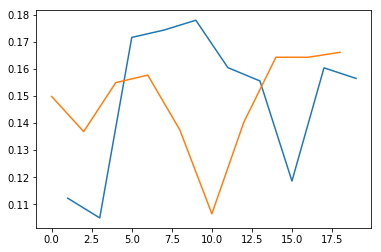

In [4]:
%matplotlib inline
rs2.loc[rs2["inv_msa_match"] == True, "sim_docvecs"].plot.line()
rs2.loc[rs2["inv_msa_match"] == False, "sim_docvecs"].plot.line()

In [5]:
rs2

,tp_yr_from_first,inv_msa_match,sim_docvecs
0,0,False,0.149814
1,0,True,0.112256
2,1,False,0.136853
3,1,True,0.104961
4,2,False,0.154938
5,2,True,0.171631
6,3,False,0.157705
7,3,True,0.174332
8,4,False,0.137479
9,4,True,0.177974
